# 第8章: ニューラルネット

In [1]:
# GPUメモリの使用状況の確認
!nvidia-smi

Tue May 17 07:50:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:01:00.0 Off |                  Off |
| 30%   27C    P8    24W / 300W |   2181MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:25:00.0 Off |                  Off |
| 30%   

In [2]:
import os
# 使用するGPUを指定
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch
from torch import nn
# 確認
print('device_count:', torch.cuda.device_count())
print('current device num:', torch.cuda.current_device())

device_count: 1
current device num: 0


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-05-14 11:24:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  30.3MB/s    in 0.9s    

2022-05-14 11:24:14 (30.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [4]:
import gdown
from gensim.models import KeyedVectors

# # 学習済み単語ベクトルのダウンロード
# url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
# output = 'GoogleNews-vectors-negative300.bin.gz'
# gdown.download(url, output, quiet=True)

# ダウンロードファイルのロード
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

## 70. 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．
各titleを形態素解析し、単語列に変換する。その単語列を一つずつベクトル化し、その平均値をそのtitleのベクトルとする。


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 読み込み
df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])

# 抽出
df = df.loc[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['title', 'category']]

# 分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=0, stratify=df['category'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=0, stratify=valid_test['category'])

# 確認
print('【学習データ】')
print(train['category'].value_counts())
print('【検証データ】')
print(valid['category'].value_counts())
print('【評価データ】')
print(test['category'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: category, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: category, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: category, dtype: int64


In [6]:
from nltk import *

In [7]:
download('punkt')
download('wordnet')
download('averaged_perceptron_tagger')

stemmer = stem.PorterStemmer()
lemmatizer = stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
import numpy as np
import re

# 文字列の前処理
def char_processing(text):
    text = re.sub(r'[^\w\s]', ' ', text) # スペース以外の記号文字全てをスペースに置換
    text = re.sub(r'\s{2,}', ' ', text) # ２個以上のスペースは一つに置換
    text = text.lower() # 小文字化
    text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換
    return text

# 各単語の見出し語を返す
def lemma(word,pos):
    if pos.startswith('J'): # 形容詞
        return lemmatizer.lemmatize(word, pos="a")
    elif pos.startswith('V'): # 動詞
        return lemmatizer.lemmatize(word, pos="v")
    elif pos.startswith('N'): # 名詞
        return lemmatizer.lemmatize(word, pos="n")
    elif pos.startswith('R'): # 副詞
        return lemmatizer.lemmatize(word, pos="r")
    else:
        return word

# 文章を見出し語列に変換する
def lemma_text(text):
    tokens = word_tokenize(text) # 分かち書き
    tokens = [lemma(word,pos) for word, pos in pos_tag(tokens)]
    text = ' '.join(tokens) # token配列を文章に戻す
    return text

# 入力された文章のベクトルを生成
# 単語ごとに分割し、各単語をベクトルに変換
# 最後に列ごとに平均値を取って文章ベクトルとする
def word2vec(text):
    words = text.split(' ')
    vecs = []
    for w in words:
        # 単語がモデルのvocabに含まれていたらそのベクトルを採用
        if w in model:
            vecs.append(model[w])
        # 含まれていなければ見出し語に変換したもののベクトルを採用
        elif lemma_text(w) in model:
            vecs.append(model[lemma_text(w)])
        # それでも含まれていない場合はスキップ
        else:
            pass
    # ベクトルが求められない場合は、停止.(本データでは存在しなかった)
    assert len(vecs)>0, 'All words are not included!' 
    return torch.tensor(np.mean(vecs, axis=0)) # 列ごとに平均を取る

# 前処理
def processing(text):
    text = char_processing(text)
    return word2vec(text)

In [18]:
#　前処理
x_train = torch.stack([processing(text) for text in train['title']])
x_valid = torch.stack([processing(text) for text in valid['title']])
x_test = torch.stack([processing(text) for text in test['title']])

category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train = torch.tensor(train['category'].map(lambda y: category_dict[y]).values)
y_valid = torch.tensor(valid['category'].map(lambda y: category_dict[y]).values)
y_test = torch.tensor(test['category'].map(lambda y: category_dict[y]).values)

## 71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み、学習データについて以下の計算を実行せよ
$$
\hat{y}_1 = softmax(\bold{x_1}W), \hat{Y}_1 = softmax(\bold{X_{[1:4]}}W), 
$$
$\bold{X_{[1:4]}}$は特徴ベクトル$\bold{x_1}$~$\bold{x_4}$を縦に並べたもの

行列$W$は$d\times L$のランダムな値で初期化された単層ニューラルネットワーク重み行列

$d$:単語ベクトルの次元数300

$L$:ラベルの種類数

**torch.Tensor**: Tensor型.実際にはnumpyのndarray型ととても似ており,ベクトル表現から行列表現,それらの演算といった機能が提供されている.

In [9]:
# 乱数によって初期化された300×4行列
W = torch.randn(300, 4)
# 特徴ベクトルx1
x1 = x_train[:1]
# XとWの内積
xW = torch.matmul(x1, W)

# 行方向のsoftmaxの演算
softmax = nn.Softmax(dim=1)
y_hat = softmax(xW)
print(y_hat)

# x1~x4の特徴ベクトル
X = x_train[:4]
XW = torch.matmul(X, W)
Y_hat = softmax(XW)
print(Y_hat)

tensor([[0.1550, 0.3453, 0.1722, 0.3274]])
tensor([[0.1550, 0.3453, 0.1722, 0.3274],
        [0.1329, 0.0542, 0.0256, 0.7874],
        [0.2831, 0.3774, 0.1517, 0.1877],
        [0.3846, 0.2298, 0.0709, 0.3147]])


## 72. 損失と勾配の計算
学習データ事例$x_1$と事例集合$x_1,x_2,x_3,x_4$に対して、クロスエントロピー損失と、行列$W$に対する勾配を計算せよ.
$$
l_i = -log[事例x_iがy_iに分類される確率]
$$

ただし、事例集合に対するクロスエントロピー損失はその集合に含まれる各事例の損失の平均とする


**requires_grad**:勾配を自動で計算することを定義する引数
**backward()**:バックワードモードの自動微分.出力側から順番に計算する。

計算グラフを作成したあと、微分対象のテンソルの Tensor.backward() を呼び出します。すると、逆伝搬が行われ、Tensor.grad 属性に計算した微分係数が記録されます。



In [10]:
# 事例x1
W = torch.randn(300, 4, requires_grad = True)
# 損失関数
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(torch.matmul(x_train[:1], W), y_train[:1])
print(f'損失{loss: .4f}')
# 勾配
loss.backward()
print('勾配', W.grad)

# 事例集合
W = torch.randn(300, 4, requires_grad = True)
loss = loss_fn(torch.matmul(x_train[:4], W), y_train[:4])
print(f'損失{loss: .4f}')
# 勾配
loss.backward()
print('勾配', W.grad)

損失 0.4943
勾配 tensor([[ 0.0820, -0.0115, -0.0558, -0.0146],
        [-0.0190,  0.0027,  0.0130,  0.0034],
        [ 0.0044, -0.0006, -0.0030, -0.0008],
        ...,
        [ 0.0050, -0.0007, -0.0034, -0.0009],
        [-0.0401,  0.0056,  0.0273,  0.0071],
        [ 0.0281, -0.0040, -0.0192, -0.0050]])
損失 2.3963
勾配 tensor([[ 0.0871, -0.0457, -0.0366, -0.0048],
        [-0.0229,  0.0106,  0.0109,  0.0013],
        [-0.0164, -0.0066,  0.0192,  0.0039],
        ...,
        [-0.0163,  0.0063,  0.0091,  0.0009],
        [-0.0431,  0.0110,  0.0267,  0.0055],
        [ 0.0236, -0.0206, -0.0037,  0.0008]])


## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

**Dataset**: 特徴量と正解ラベルのセット. データと対応する1組のラベルを返すもの
**DataLoader**: Datasetからバッチサイズずつデータを取り出す

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# データセット
ds = TensorDataset(x_train, y_train)
# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

# 行列W
W = torch.randn(300, 4, requires_grad=True)
# 損失関数
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(100):
    for inputs, targets in loader:
        # 損失
        loss = loss_fn(torch.matmul(inputs, W), targets)
        # 勾配
        loss.backward()
        # 更新
        W = (W - W.grad * 0.01).detach().requires_grad_()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: loss={loss: .4f}")

Epoch 10: loss= 0.5873
Epoch 20: loss= 0.3231
Epoch 30: loss= 0.0150
Epoch 40: loss= 0.0708
Epoch 50: loss= 0.0089
Epoch 60: loss= 0.0001
Epoch 70: loss= 0.0092
Epoch 80: loss= 0.0376
Epoch 90: loss= 0.0449
Epoch 100: loss= 0.0428


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

**with torch.no_grad()**: そのブロック中は勾配の計算を不可にすることでメモリの消費量を減らす

In [12]:
# 入力されたデータから予測分類ラベルを返す
def pred(inputs, W):
    softmax = torch.nn.Softmax(dim=1)
    # 分類の確率
    class_probs = softmax(torch.matmul(inputs, W))
    # 確率最大のインデックスを取得
    class_idx = torch.argmax(class_probs, dim=1)

    return class_idx

# 予測ラベルと正解ラベルから正解率を返す
def accuracy(pred, targets):
    correct = 0
    for p, t in zip(pred, targets):
        if p == t:
            correct += 1

    return correct / len(pred)

# 訓練データの正解率
with torch.no_grad():
    train_pred = pred(x_train, W)
    train_accuracy = accuracy(train_pred, y_train)
print(f'train accuracy:{train_accuracy: .3f}')


# 評価データの正解率
with torch.no_grad():
    test_pred = pred(x_test, W)
    test_accuracy = accuracy(test_pred, y_test)
print(f'test accuracy:{test_accuracy: .3f}')

train accuracy: 0.908
test accuracy: 0.892


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

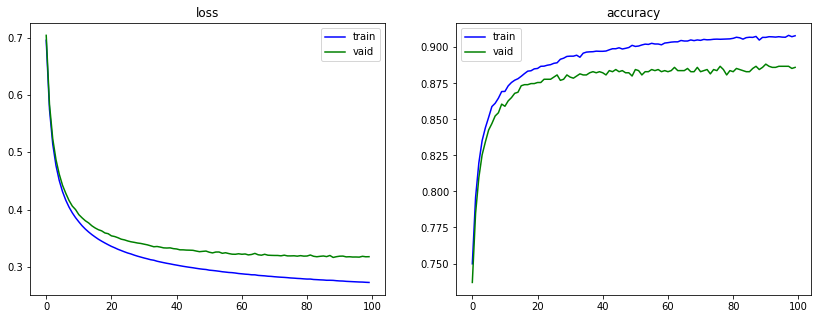

In [13]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

# データ更新があるたびにグラフを更新する関数
def live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies):
    # グラフ準備
    clear_output(wait=True)
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    # 損失をplot
    ax[0].plot(train_losses,c='blue', label='train')
    ax[0].plot(valid_losses,c='green', label='vaid')
    ax[0].set_title('loss')
    ax[0].legend()
    # 正解率をplot
    ax[1].plot(train_accuracies,c='blue', label='train')
    ax[1].plot(valid_accuracies,c='green', label='vaid')
    ax[1].set_title('accuracy')
    ax[1].legend()
    plt.show()

# データセット
ds = TensorDataset(x_train, y_train)
# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

# 行列W
W = torch.randn(300, 4, requires_grad=True)
# 損失関数
loss_fn = torch.nn.CrossEntropyLoss()

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率


for epoch in range(100):
    x = [i for i in range(epoch+1)] # グラフx軸
    for inputs, targets in loader:
        # 損失
        loss = loss_fn(torch.matmul(inputs, W), targets)
        # 勾配
        loss.backward()
        # 更新
        W = (W - W.grad * 0.01).detach().requires_grad_()

    # 学習の進捗
    with torch.no_grad():
        # 訓練
        train_pred = pred(x_train, W)
        train_accuracy = accuracy(train_pred, y_train)
        train_loss = loss_fn(torch.matmul(x_train, W), y_train).item()
        # 検証
        valid_pred = pred(x_valid, W)
        valid_accuracy = accuracy(valid_pred, y_valid)
        valid_loss = loss_fn(torch.matmul(x_valid, W), y_valid).item()
    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ

### 最適化手法
主に損失関数の最小値(とその時のパラメータ)を求めるアルゴリズム

|最適化手法|説明|
|:--|:--|
|SGD（Stochastic Gradient Decent : 確率的勾配降下法）|ランダムに拾った1つのデータを使って、求めた勾配方向に求めた大きさだけパラメータを更新する手法。△：複雑な状況では最適化が進みにくい。並列処理ができない|
|SDG – ミニバッチ(Mini-batch)|SDGでミニバッチを使い、1回の更新で一定数のデータを使って学習する手法。△：データによっては学習が異常に遅くなることがある|
|SDG – モーメンタム(Momentum)|過去の動き(勾配の移動平均)を考慮することでSDGの振動を抑えるという手法。△：過去の結果が間違ったベクトルであっても反映されてしまう|
|Adagrad（Adaptive Gradient Algorithm）|学習率を学習の中で更新し続ける手法。パラメータの学習率を制御し大きな勾配の影響を小さくすることで、効率的に最適化を進めることができる△：学習が進むと学習率が小さくなり更新されなくなる|
|RMSprop（Root Mean Square propagation）|Adagradに比べ、古い勾配情報よりも新しい勾配情報が反映されやすい手法。学習が進んでも学習率の調整が適切に行われる|
|Adam（Adaptive Moment Estimation）|移動平均で振動を抑制するモーメンタムと、学習率で振動を抑制するRMSpropを組み合わせたもの。複雑な形状でも適切な方向を探すことができる|
|Adadelta|更新量 = (過去の更新量の移動平均)/(過去の勾配の移動平均)*(現在の勾配)△：収束が少し遅い|
|AdamW|Adamよりも最適な重み減衰(Weight decay)を加えた手法。損失関数計算およびパラメータ更新時にリッジ回帰を追加したもの|

などがある.今回はSGDを採用する

最適化アルゴリズムの内部状態とは以下のようなハイパーメータの情報

Optimizer's state_dict:

state: 現在のオプティマイザーの状態

param_groups:  [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [139665281919328, 139665281919488, 139665281919568, 139665281919648, 139665281919728, 139665281919808, 139665281922384, 139665281919408, 139665281919888, 139665281919968]}]

逆伝搬で勾配を計算した際に、以前に計算した勾配がある場合はそれに加算する形になっている。

今回の勾配 = 前回計算した勾配 + 今回計算した勾配


この仕様は RNN などのモデルでは有用だが、そうでない場合は前回計算した勾配を0で初期化する必要があるので、その場合は backward() を呼び出す前に zero_grad() を行う必要がある。



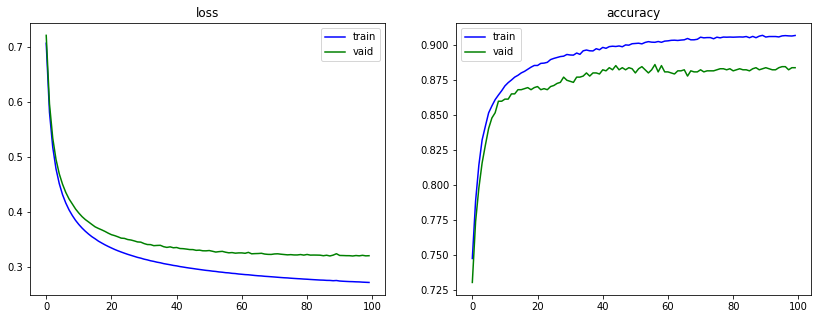

In [ ]:
import torch.optim as optim
import os
import shutil

# データセット
ds = TensorDataset(x_train, y_train)
# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

# 行列W
W = torch.randn(300, 4, requires_grad=True)
# 損失関数
loss_fn = torch.nn.CrossEntropyLoss()

train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率

# 最適化
optimizer = optim.SGD([W], lr=0.01)
# checkpoint用フォルダ
path = './SGDparams'
shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

for epoch in range(100):
    x = [i for i in range(epoch+1)] # グラフx軸
    for inputs, targets in loader:
        # 損失
        loss = loss_fn(torch.matmul(inputs, W), targets)
        # 勾配
        optimizer.zero_grad() # 勾配を初期化
        loss.backward() 
        # 更新
        optimizer.step()

    # 学習の進捗
    with torch.no_grad():
        # 訓練
        train_pred = pred(x_train, W)
        train_accuracy = accuracy(train_pred, y_train)
        train_loss = loss_fn(torch.matmul(x_train, W), y_train).item()
        # 検証
        valid_pred = pred(x_valid, W)
        valid_accuracy = accuracy(valid_pred, y_valid)
        valid_loss = loss_fn(torch.matmul(x_valid, W), y_valid).item()

    # 保存
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'W': W, 'optimizer_state_dict': optimizer.state_dict(),'loss': loss, 'accuracy': train_accuracy}, f'{path}/epoch_{epoch}')

In [ ]:
for epoch in ['0', '99']:
    checkpoint = torch.load(f'{path}/epoch_{epoch}')
    print(f'epoch: {epoch}')
    print(f"loss: {checkpoint['loss']:.4f}, accuracy: {checkpoint['accuracy']:.3f}")
    print(checkpoint['W'])
    print(checkpoint['optimizer_state_dict'], '\n')

epoch: 0
loss: 0.3175, accuracy: 0.747
tensor([[-0.1080,  1.2783,  0.0266,  0.9463],
        [-1.3929, -0.9870, -0.5143, -0.5880],
        [-0.1870,  0.2962, -1.6134, -1.1152],
        ...,
        [-1.7901, -0.9168,  0.4666,  0.6725],
        [-1.1010, -1.0090,  0.0170,  1.5039],
        [-0.9482,  1.0074,  0.3575,  0.4051]], requires_grad=True)
{'state': {0: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'params': [0]}]} 

epoch: 99
loss: 0.0012, accuracy: 0.907
tensor([[-0.3199, -0.1632,  1.6803,  0.9457],
        [-1.3211, -0.1069, -1.2346, -0.8190],
        [ 0.3764, -2.1728, -0.9307,  0.1076],
        ...,
        [-1.3150, -0.3111, -0.5531,  0.6112],
        [-0.7124, -0.5038, -0.3920,  1.0195],
        [-1.8852,  1.4999, -1.4969,  2.7042]], requires_grad=True)
{'state': {0: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.01, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 

## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ

In [16]:
import torch.optim as optim
import time

# データセット
ds = TensorDataset(x_train, y_train)


# バッチサイズ 1~256
batch_sizes = [2**i for i in range(8)]

# 結果を保存
result = []

for batch_size in batch_sizes:
    # DataLoaderを作成
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    # 行列W
    W = torch.randn(300, 4, requires_grad=True)
    # 損失関数
    loss_fn = torch.nn.CrossEntropyLoss()
    # 最適化
    optimizer = optim.SGD([W], lr=0.01)

    # データ
    train_losses = [] # 学習データの損失
    train_accuracies = [] # 学習データの正解率
    valid_losses = [] # 検証データの損失
    valid_accuracies = [] # 検証データの正解率
    
    print('batch size: ', batch_size)
    start = time.time()

    for epoch in range(1, 11):
        for inputs, targets in loader:
            # 損失
            loss = loss_fn(torch.matmul(inputs, W), targets)
            # 勾配
            optimizer.zero_grad()
            loss.backward()
            # 更新
            optimizer.step()

        # 学習の進捗
        with torch.no_grad():
            # 訓練
            train_pred = pred(x_train, W)
            train_accuracy = accuracy(train_pred, y_train)
            train_loss = loss_fn(torch.matmul(x_train, W), y_train).item()
            # 検証
            valid_pred = pred(x_valid, W)
            valid_accuracy = accuracy(valid_pred, y_valid)
            valid_loss = loss_fn(torch.matmul(x_valid, W), y_valid).item()

        # 保存
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
    
    # 1epochあたりの時間を計算
    t = (time.time()-start) / 10
    print(f'time / ephocs: {t}\n')
    
    # batch_sizeごとの結果を保存
    result.append([batch_size, t, train_losses, train_accuracies, valid_losses, valid_accuracies])

batch size:  1
time / ephocs: 4.565398740768432

batch size:  2
time / ephocs: 2.3079686641693113

batch size:  4
time / ephocs: 1.1546008110046386

batch size:  8
time / ephocs: 0.6769380331039428

batch size:  16
time / ephocs: 0.45405466556549073

batch size:  32
time / ephocs: 0.2574853658676147

batch size:  64
time / ephocs: 0.19614112377166748

batch size:  128
time / ephocs: 0.16137998104095458



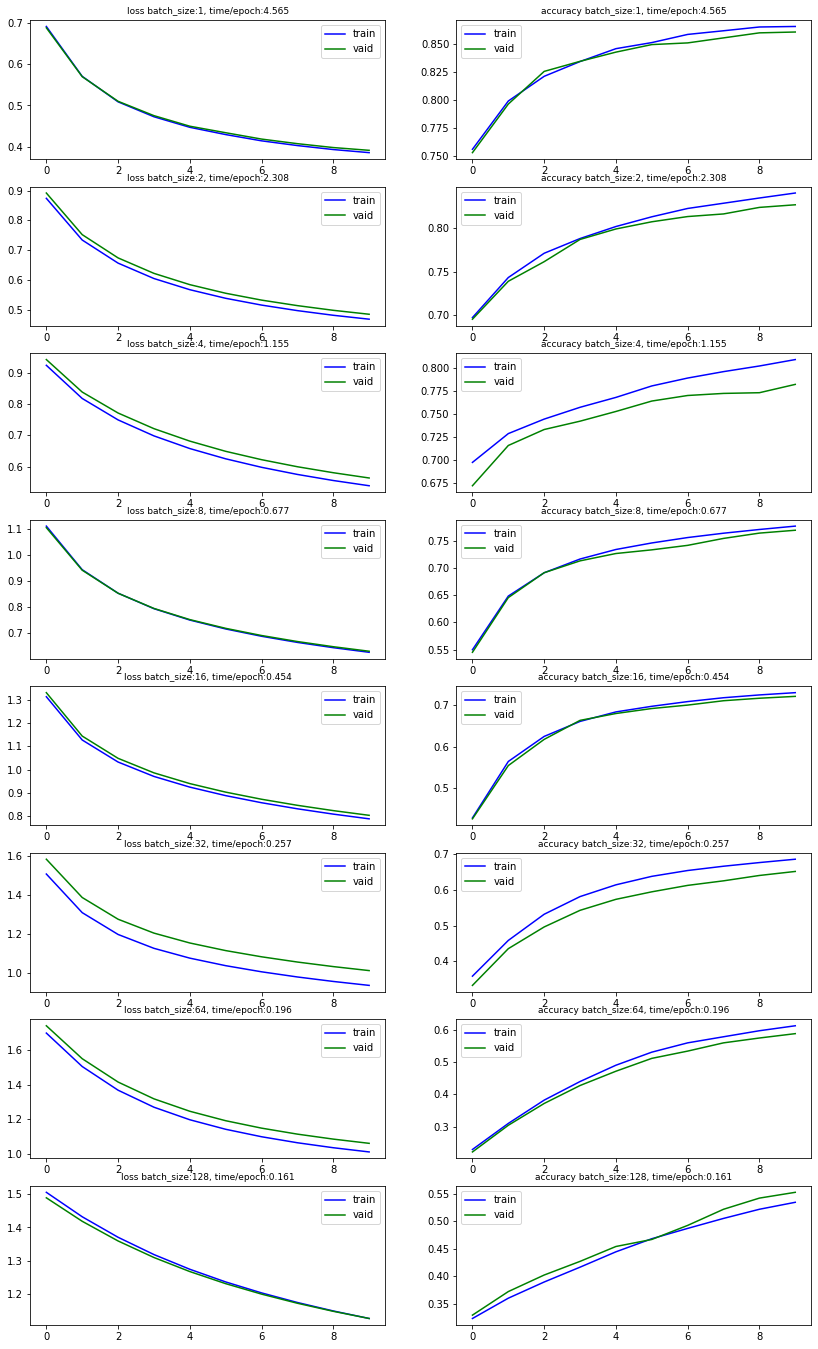

In [24]:
num = len(batch_sizes)
fig, axes = plt.subplots(num, 2,figsize=(14,3*num))
for b_size, data, ax in zip(batch_sizes, result, axes):
    
    # 損失をplot
    ax[0].plot(data[2], c='blue', label='train')
    ax[0].plot(data[4], c='green', label='vaid')
    ax[0].set_title(f'loss batch_size:{b_size}, time/epoch:{data[1]:.3f}', fontsize=9)
    ax[0].legend()
    # 正解率をplot
    ax[1].plot(data[3], c='blue', label='train')
    ax[1].plot(data[5], c='green', label='vaid')
    ax[1].set_title(f'accuracy batch_size:{b_size}, time/epoch:{data[1]:.3f}', fontsize=9)
    ax[1].legend()

plt.show()

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

to()はコピーを作るため、微分情報を持たせたい変数は以下のようにする。
```
x.to(device).detach().requires_grad_(True)
```

In [48]:
# GPU
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# データセット
ds = TensorDataset(x_train.to(device), y_train.to(device))


# バッチサイズ 1~256
batch_sizes = [2**i for i in range(8)]

# 結果を保存
GPUresult = []

for batch_size in batch_sizes:
    # DataLoaderを作成
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    # 行列W
    W = torch.randn(300, 4).to(device).detach().requires_grad_(True)
    # 損失関数
    loss_fn = torch.nn.CrossEntropyLoss()
    # 最適化
    optimizer = optim.SGD([W], lr=0.01)

    # データ
    train_losses = [] # 学習データの損失
    train_accuracies = [] # 学習データの正解率
    valid_losses = [] # 検証データの損失
    valid_accuracies = [] # 検証データの正解率
    
    print('batch size: ', batch_size)
    start = time.time()

    for epoch in range(1, 11):
        for inputs, targets in loader:
            # 損失
            loss = loss_fn(torch.matmul(inputs, W), targets).to(device)
            # 勾配
            optimizer.zero_grad()
            loss.backward()
            # 更新
            optimizer.step()

        # 学習の進捗
        with torch.no_grad():
            # 訓練
            train_pred = pred(x_train.to(device), W)
            train_accuracy = accuracy(train_pred, y_train)
            train_loss = loss_fn(torch.matmul(x_train.to(device), W), y_train.to(device)).item()
            # 検証
            valid_pred = pred(x_valid.to(device), W)
            valid_accuracy = accuracy(valid_pred, y_valid)
            valid_loss = loss_fn(torch.matmul(x_valid.to(device), W), y_valid.to(device)).item()

        # 保存
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
    
    # 1epochあたりの時間を計算
    t = (time.time()-start) / 10
    print(f'time / ephocs: {t}\n')
    
    # batch_sizeごとの結果を保存
    GPUresult.append([batch_size, t, train_losses, train_accuracies, valid_losses, valid_accuracies])


batch size:  1
time / ephocs: 9.792664766311646

batch size:  2
time / ephocs: 4.731396150588989

batch size:  4
time / ephocs: 2.734801697731018

batch size:  8
time / ephocs: 1.590060257911682

batch size:  16
time / ephocs: 1.1289345741271972

batch size:  32
time / ephocs: 0.7828352689743042

batch size:  64
time / ephocs: 0.6567806243896485

batch size:  128
time / ephocs: 0.5864072561264038



In [61]:
cpu_re = pd.DataFrame(result, columns=['batch_size', 'time_pre_epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])
gpu_re = pd.DataFrame(GPUresult, columns=['batch_size', 'time_pre_epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])
pd.concat([cpu_re['time_pre_epoch'], gpu_re['time_pre_epoch']], axis=1).set_axis(['CPU', 'GPU'], axis='columns')

,CPU,GPU
0,4.565399,9.792665
1,2.307969,4.731396
2,1.154601,2.734802
3,0.676938,1.590060
4,0.454055,1.128935
5,0.257485,0.782835
6,0.196141,0.656781
7,0.161380,0.586407


学習モデルが簡単だったため、GPUを利用するメリットよりも、GPUにデータをコピーする時間が強く影響してしまったため、CPUを利用した方がtime_per_epochが短かったと考えられる。

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ

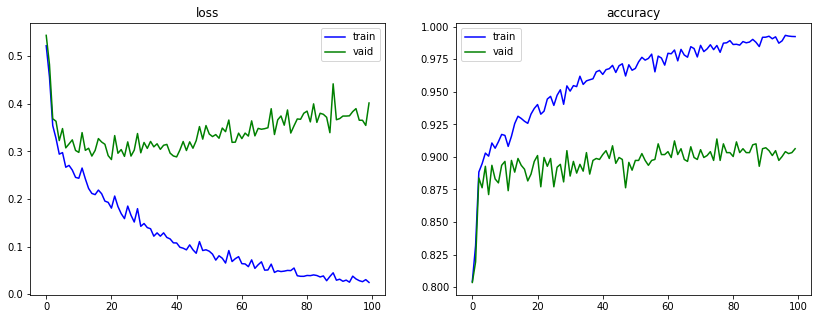

In [35]:
import torch.optim as optim
import torch.nn.functional as F
import time

class MLN(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        return x

# GPU
torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# データセット
ds = TensorDataset(x_train.to(device), y_train.to(device))
# DataLoaderを作成
loader = DataLoader(ds, batch_size=1, shuffle=True)

# hyper parameters
input_size = 300
output_size = 4
epochs = 100
# 損失関数
loss_fn = torch.nn.CrossEntropyLoss()

# データ
train_losses = [] # 学習データの損失
train_accuracies = [] # 学習データの正解率
valid_losses = [] # 検証データの損失
valid_accuracies = [] # 検証データの正解率

# モデル
model = MLN(input_size, output_size).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1, epochs + 1):
    for inputs, targets in loader:
        # forward
        model.train()
        outputs = model(inputs)
        # 損失
        loss = loss_fn(outputs, targets).to(device)
        # 勾配
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()

    # loss, accuracy
    model.eval()
    with torch.no_grad():
        train_pred = model(x_train.to(device))
        train_accuracy = accuracy(torch.argmax(train_pred.to(device), dim=1), y_train)
        train_loss = loss_fn(train_pred.to(device), y_train.to(device)).item()

        valid_pred = model(x_valid.to(device))
        valid_accuracy = accuracy(torch.argmax(valid_pred.to(device), dim=1), y_valid.to(device))
        valid_loss = loss_fn(valid_pred.to(device), y_valid.to(device)).item()


    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # グラフの描画
    live_plot(train_losses, train_accuracies, valid_losses, valid_accuracies)